In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class WalkEnv:
  def __init__(self, states=1000, step_size=100):
    self.states = states
    self.step_size = step_size

  def step(self, s):
    direction = 1 if np.random.random() > 0.5 else -1
    step_size = np.random.randint(1, high=self.step_size+1)
    a = direction*step_size

    sp, r = self.bound_state(s + a)

    return s, a, r, sp, not r==0

  def bound_state(self, s):
    if s <=0:
      return 0, -1
    elif s >= self.states+1:
      return self.states+1, 1
    else:
      return s, 0

  def get_states(self):
    return self.states

  def get_step_size(self):
    return self.step_size

In [39]:
class WalkSystem:
  def __init__(self, env, method="MC", episodes=100, tilings=1, alpha=0.01, n=0, label=None):
    self.env = env
    self.states = env.get_states()
    self.step_size = env.get_step_size()

    self.T = episodes
    self.tilings = tilings
    self.alpha = alpha
    self.n = n
    self.label = label

    self.v = np.zeros((self.tilings, 2+int(self.states/self.step_size)+1))
    self.tile_width = self.step_size/self.tilings

    self.method_map = {
        "MC": self.MC,
        "TD": self.TD
    }
    self.method = self.method_map.get(method, None)

  def run(self):
    for episode in range(self.T):
      s, done = 500, False
      self.method(s, done)
    return self.v

  def MC(self, s, done):
    moves = []
    while not done:
      s, a, r, sp, done = self.env.step(s)
      moves.append((s, a, r, sp))
      s = sp

    i = len(moves) - 1
    while i >= 0:
      s_i, a_i, r_i, sp_i = moves[i]

      s_features = self.get_features(s_i)
      sp_features = self.get_features(sp_i)

      for tile in range(self.tilings):
        self.v[s_features[tile]] += self.alpha*(r_i + self.v[sp_features[tile]] - self.v[s_features[tile]])
      
      i -= 1

  def TD(self, s, done):
    t = 0
    tau = 0
    T = 100000
    s_list = [s]
    r_list = [0]

    while tau < T:
      if t < T:
        s = s_list[-1]
        s, a, r, sp, done = self.env.step(s)
        r_list.append(r)
        s_list.append(sp)
        if done:
          T = t + 1

      tau = t - self.n + 1

      if tau >= 0:
        s_features = self.get_features(s)
        sp_features = self.get_features(sp)

        for tile in range(self.tilings):
          G = np.sum(r_list)
          G += self.v[sp_features[tile]] if tau + self.n < T else 0
          self.v[s_features[tile]] += self.alpha*(G - self.v[s_features[tile]])

        s_list.pop(0)
        r_list.pop(0)

      t += 1

    ########## for TD(0) ##########

    # while not done:
    #   s, a, r, sp, done = self.env.step(s)

    #   s_features = self.get_features(s)
    #   sp_features = self.get_features(sp)

    #   for tile in range(self.tilings):
    #     self.v[s_features[tile]] += self.alpha*(r + self.v[sp_features[tile]] - self.v[s_features[tile]])

    #   s = sp
  
  # v is a function of all of the tiles at a state: v(s,w)
  def get_features(self, s):
    terminal = False if 1 <= s <= self.states else True
    features = [(i, int((s + self.step_size-1 + self.tile_width*i)/self.step_size) if not terminal else (0 if s <= 0 else self.v.shape[1]-1)) for i in range(self.tilings)]
    return features

  def get_v(self):
    return self.v

  def get_label(self):
    if self.label == None:
      for key, value in self.method_map.items(): 
        if self.method == value:
          name = str(key)
          if name == 'TD':
            name = name + "_n=" + str(self.n)
          return name + "_Tiles=" + str(self.tilings)
    return self.label

In [40]:
# Takes about 30 seconds for 500 episodes
system_MC_star = WalkSystem(WalkEnv(states=1000, step_size=10), method='MC', episodes=100, alpha=0.3, label="MC-star_Tiles=1")
v_MC_star = system_MC_star.run()

In [41]:
system_MC = WalkSystem(WalkEnv(1000,100), method='MC', episodes=3000)
v_MC = system_MC.run()

In [44]:
system_TD = WalkSystem(WalkEnv(1000,100), method="TD", episodes=3000, n=5)
v_TD = system_TD.run()

In [43]:
# The benefit of tiling is that it gives the same granularity as taking smaller step sizes, but trains much faster
system_MC_tile10 = WalkSystem(WalkEnv(1000,100), method="MC", episodes=3000, tilings=10)
v_MC_tile10 = system_MC_tile10.run()

In [45]:
def add_plot(sys, states):
  plt.plot([np.average([sys.get_v()[i] for i in sys.get_features(s+1)]) for s in range(states)], label=sys.get_label())

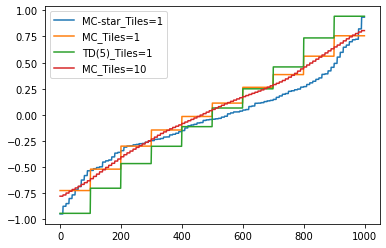

In [46]:
add_plot(system_MC_star, 1000)
add_plot(system_MC, 1000)
add_plot(system_TD, 1000)
add_plot(system_MC_tile10, 1000)
plt.legend()
plt.show()

In [ ]:
# Didn't implement anything else after this point